<a href="https://colab.research.google.com/github/Kane-Kesler/SeaturlteIDHeads-CNN-Model/blob/main/CIFAR10_CNN_model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

100%|██████████| 170498071/170498071 [00:11<00:00, 15367090.83it/s]


Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified
[epoch] 1 train loss: 0.07156 train acc: 0.4847 valid loss: 0.06083 valid acc: 0.5617
[epoch] 2 train loss: 0.05923 train acc: 0.5819 valid loss: 0.05139 valid acc: 0.6326
[epoch] 3 train loss: 0.05441 train acc: 0.6185 valid loss: 0.04772 valid acc: 0.6676
[epoch] 4 train loss: 0.05122 train acc: 0.6426 valid loss: 0.04510 valid acc: 0.6854
[epoch] 5 train loss: 0.04888 train acc: 0.6551 valid loss: 0.04238 valid acc: 0.6993
[epoch] 6 train loss: 0.04718 train acc: 0.6695 valid loss: 0.04137 valid acc: 0.7164
[epoch] 7 train loss: 0.04520 train acc: 0.6873 valid loss: 0.03945 valid acc: 0.7250
[epoch] 8 train loss: 0.04392 train acc: 0.6938 valid loss: 0.03809 valid acc: 0.7290
[epoch] 9 train loss: 0.04317 train acc: 0.6989 valid loss: 0.03835 valid acc: 0.7310
[epoch] 10 train loss: 0.04206 train acc: 0.7052 valid loss: 0.03753 valid acc: 0.7333
[epoch] 11 train loss: 0.04087 train acc: 0.7169 v

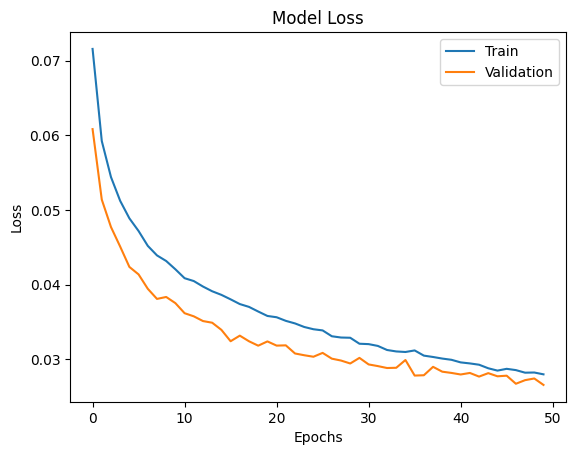

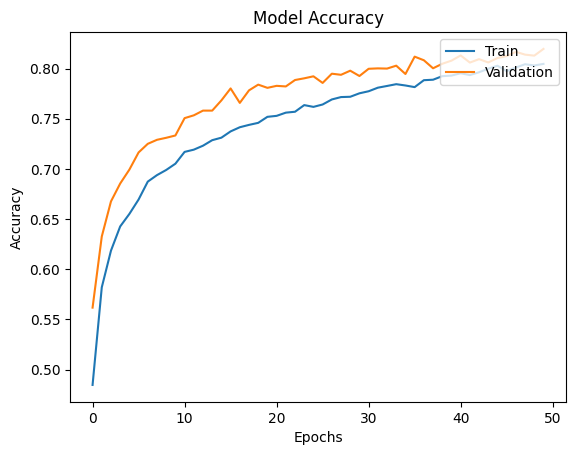

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Accuracy of the network: 82.25 %
Accuracy of plane: 86.0 %
Accuracy of car: 90.7 %
Accuracy of bird: 71.9 %
Accuracy of cat: 64.7 %
Accuracy of deer: 83.9 %
Accuracy of dog: 77.2 %
Accuracy of frog: 86.0 %
Accuracy of horse: 84.2 %
Accuracy of ship: 89.3 %
Accuracy of truck: 88.6 %


''

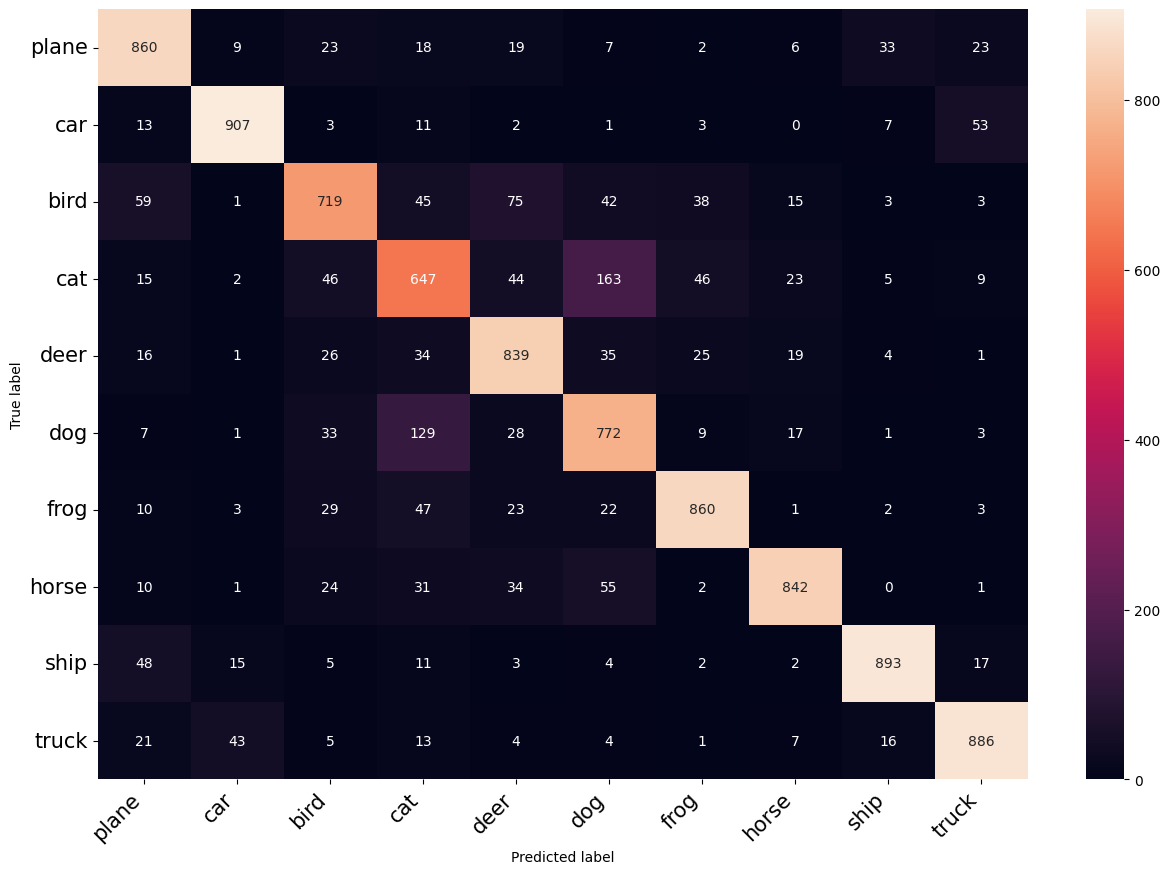

In [ ]:
#@title CIFAR10 CNN model
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
import torch.optim.lr_scheduler as lr_scheduler
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import pandas as pd
from google.colab import files


# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Hyper-parameters 
num_epochs = 50
batch_size = 20
learning_rate = 0.001

# dataset has PILImage images of range [0, 1]
# We transform them to Tensors of normalized range [-1, 1]
train_transform = transforms.Compose(
    [transforms.RandomHorizontalFlip(p=0.5),
     transforms.RandomRotation(degrees=10),
     transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

test_transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

# CIFAR10: 60000 32x32 color images in 10 classes, with 6000 images per class
# (index, images, label)
dataset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                       download=True, transform=train_transform)

train_dataset, valid_dataset = torch.utils.data.random_split(dataset, [40000, 10000])

test_dataset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=test_transform)

# Wrap the datasets as iterable object
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size,
                                          shuffle=True, num_workers=2)

valid_loader = torch.utils.data.DataLoader(valid_dataset, batch_size=batch_size,
                                          shuffle=False, num_workers=2)

test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size,
                                         shuffle=False, num_workers=2)

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')


# define the network architecture
class ConvNet(nn.Module):
    def __init__(self):
        super(ConvNet, self).__init__()
        # convolutional layer (sees 32x32x3 image tensor)
        self.conv1 = nn.Conv2d(3, 16, 3, padding=1)
        # convolutional layer (sees 16x16x16 tensor)
        self.conv2 = nn.Conv2d(16, 32, 3, padding=1)
        # convolutional layer (sees 8x8x32 tensor)
        self.conv3 = nn.Conv2d(32, 64, 3, padding=1)
        # max pooling layer
        self.pool = nn.MaxPool2d(2, 2)
        # linear layer (64 * 4 * 4 -> 500)
        self.fc1 = nn.Linear(64 * 4 * 4, 500)
        # linear layer (500 -> 250)
        self.fc2 = nn.Linear(500, 250)
        # linear layer (250 -> 10)
        self.fc3 = nn.Linear(250, 10)
        # dropout layer (p=0.25)
        self.dropout = nn.Dropout(0.25)
        # batch normalization for convolution layer 1 output
        self.bn_conv1 = nn.BatchNorm2d(16)
        # batch normalization for convolution layer 2 output
        self.bn_conv2 = nn.BatchNorm2d(32)
        # batch normalization for convolution layer 3 output
        self.bn_conv3 = nn.BatchNorm2d(64)
        # batch noramlization for fully connected layer 1 output
        self.bn_dense1 = nn.BatchNorm1d(500) 
        # batch noramlization for fully connected layer 2 output
        self.bn_dense2 = nn.BatchNorm1d(250) 
        

    def forward(self, x):
        # add sequence of convolutional and max pooling layers (batch normalization)
        x = self.pool(F.elu(self.bn_conv1(self.conv1(x))))
        x = self.pool(F.elu(self.bn_conv2(self.conv2(x))))
        x = self.pool(F.elu(self.bn_conv3(self.conv3(x))))
        # flatten image input
        x = x.view(-1, 64 * 4 * 4)
        # add dropout layer
        x = self.dropout(x)
        # add 1st hidden layer, with relu activation function
        x = F.elu(self.bn_dense1(self.fc1(x)))
        # add dropout layer
        x = self.dropout(x)
        # add 2nd hidden layer, with relu activation function
        x = F.elu(self.bn_dense2(self.fc2(x)))
        # add dropout layer
        x = self.dropout(x)
        # add 3rd hidden layer, with relu activation function
        x = self.fc3(x)
        return x



model = ConvNet().to(device)

# define loss and optimizer and learning rate scheduler
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
scheduler = lr_scheduler.ReduceLROnPlateau(optimizer, verbose=True)

# these lists will be used to plot the accuracy and loss against epochs
train_loss_hist, train_acc_hist = [], []
valid_loss_hist, valid_acc_hist = [], []
train_total_steps = len(train_dataset)
valid_total_steps = len(valid_dataset)

# Train the model
for epoch in range(num_epochs):
    # track the training loss and the number of correct predictions from training
    train_loss = 0
    train_correct = 0
    for i, (images, labels) in enumerate(train_loader):
        # origin shape: [4, 3, 32, 32] = 4, 3, 1024
        # input_layer: 3 input channels, 16 output channels, 3 kernel size
        images = images.to(device)
        labels = labels.to(device)

        # Forward pass
        outputs = model(images)
        loss = criterion(outputs, labels)

        # Backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # calculate training statistics
        _, predicted = torch.max(outputs, 1)
        train_correct += (predicted == labels).sum().item()

        # update the loss
        train_loss += loss.item()

    train_avg_loss = train_loss / train_total_steps
    train_avg_acc = train_correct / train_total_steps
    train_loss_hist.append(train_avg_loss)
    train_acc_hist.append(train_avg_acc)


    # Validate the model
    # turn off dropout and batch normalization
    model.eval()
    with torch.no_grad():
        valid_loss = 0
        valid_correct = 0
        for i, (images, labels) in enumerate(valid_loader):
            images = images.to(device)
            labels = labels.to(device)

            # Forward pass
            outputs = model(images)
            loss = criterion(outputs, labels)

            # calculate training statistics
            _, predicted = torch.max(outputs, 1)
            valid_correct += (predicted == labels).sum().item()

            # update the loss
            valid_loss += loss.item()

        valid_avg_loss = valid_loss / valid_total_steps
        valid_avg_acc = valid_correct / valid_total_steps
        valid_loss_hist.append(valid_avg_loss)
        valid_acc_hist.append(valid_avg_acc)

    # turn dropout and bacth normalization back on
    model.train()

    # update learning rate
    scheduler.step(valid_avg_loss)
    print(f'[epoch] {epoch+1} train loss: {train_avg_loss:.5f} train acc: {train_avg_acc:.4f} valid loss: {valid_avg_loss:.5f} valid acc: {valid_avg_acc:.4f}')


print('Finished Training')

# Plot training statistics
legend = ['Train', 'Validation']
print('train_loss_hist:', train_loss_hist)
print('valid_loss_hist:', valid_loss_hist)
plt.plot(train_loss_hist)
plt.plot(valid_loss_hist)
plt.title('Model Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend(legend, loc='upper right')
plt.show()

legend = ['Train', 'Validation']
plt.plot(train_acc_hist)
plt.plot(valid_acc_hist)
plt.title('Model Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(legend, loc='upper right')
plt.show()

# Save the trained model
torch.save(model.state_dict(),'checkpoint.pth')

# Download checkpoint file
files.download('checkpoint.pth')
model.load_state_dict(torch.load('checkpoint.pth'))

# testing the model
confusion_matrix = torch.zeros(10, 10)
model.eval()
with torch.no_grad():
    n_correct = 0
    n_samples = 0
    n_class_correct = [0 for i in range(10)]
    n_class_samples = [0 for i in range(10)]
    for images, labels in test_loader:
        images = images.to(device)
        labels = labels.to(device)
        outputs = model(images)
        # max returns (value ,index)
        _, predicted = torch.max(outputs, 1)
        n_samples += labels.size(0)
        n_correct += (predicted == labels).sum().item()
        for t, p in zip(labels.view(-1), predicted.view(-1)):
                confusion_matrix[t.long(), p.long()] += 1
        
        for i in range(batch_size):
            label = labels[i]
            pred = predicted[i]
            if (label == pred):
                n_class_correct[label] += 1
            n_class_samples[label] += 1

    acc = 100.0 * n_correct / n_samples
    print(f'Accuracy of the network: {acc} %')

    for i in range(10):
        acc = 100.0 * n_class_correct[i] / n_class_samples[i]
        print(f'Accuracy of {classes[i]}: {acc} %')

# produce confusion matrix
plt.figure(figsize=(15,10))

df_cm = pd.DataFrame(confusion_matrix, index=classes, columns=classes).astype(int)
heatmap = sns.heatmap(df_cm, annot=True, fmt="d")

heatmap.yaxis.set_ticklabels(heatmap.yaxis.get_ticklabels(), rotation=0, ha='right',fontsize=15)
heatmap.xaxis.set_ticklabels(heatmap.xaxis.get_ticklabels(), rotation=45, ha='right',fontsize=15)
plt.ylabel('True label')
plt.xlabel('Predicted label')
;